# K coloration d'un graphe

In [1]:
import Pkg
using LinearAlgebra
using Random
using Plots
using XLSX

## Lecture des fichiers txt

In [2]:
const n = 125
const k =5
file = "dsjc125.1.col.txt"

"dsjc125.1.col.txt"

In [3]:
function define_adjacence_list(file, n)
    """
    Lecture du fichier et Création liste d'adjacence
    """
    file_read = open(file,"r");
    lines = readlines(file_read)
    adjacence_list = Dict{Int, Vector{Int}}()
    for line in lines
        st=split(line, " ")
        if st[1]=="e"
            u=parse(Int, st[2])
            v=parse(Int, st[3])
            if haskey(adjacence_list, u)
                push!(adjacence_list[u], v)
            else
                adjacence_list[u] = [v]
            end
        
            if haskey(adjacence_list, v)
                push!(adjacence_list[v], u)
            else
                adjacence_list[v] = [u]
            end
        end
    end
    return adjacence_list
end

adjacence_list=define_adjacence_list(file, n)

"""
Calcul des degrés et l'ordre décroissant
"""
degree=zeros(Int, n)
for i in 1:n
    degree[i]=size(adjacence_list[i])[1]
end

adjacence_list=define_adjacence_list(file, n)

indice_degree = sortperm(degree, rev=true)

125-element Vector{Int64}:
  84
  62
  77
 110
  51
  69
  91
 122
  35
   9
  17
  42
  52
   ⋮
  90
 100
 121
  20
  21
  33
  39
  87
  34
  60
  95
 109

## Heuristique gloutonne

In [4]:
function random_coloring(n, k)
    """
    Coloriage aléatoire
    """
    return rand(1:k, n)
end

random_coloring (generic function with 1 method)

In [5]:
"""
Algo glouton qui parcourt les sommets selon la degré
"""

function min_color_glouton(adjacence_list, Color, k, i)
    #Renvoie une des couleurs les moins utilisées dans la liste d'adjacence
    color_used=zeros(Int, k)
    for j in adjacence_list[i]
        if Color[j]!=0
            color_used[Color[j]]+=1
        end
    end
    for index_color in 1:k
        if color_used[index_color]==0
            return index_color
        end
    end
    return argmin(color_used)
end



function glouton(adjacence_list, indice_degree, n, k)
    Color =zeros(Int, n)
    for i in indice_degree
        Color[i]=min_color_glouton(adjacence_list, Color, k, i)
    end
    return Color
end

glouton (generic function with 1 method)

In [6]:
function count_conflict(adjacence_list, Color, n)
    """
    Compte le nombre de conflits dans une solution
    """
    Count=0
    list_conflit=[] #Liste des sommets en conflit
    bool_list_conflit=[0 for i in 1:n] # 1 si le sommet est en conflit, 0 sinon 
    for i in 1:n
        for j in adjacence_list[i]
            if Color[i]==Color[j] && j>i
                Count+=1
                if bool_list_conflit[i]==0
                    bool_list_conflit[i]=1
                    push!(list_conflit,i)
                end
                if bool_list_conflit[j]==0
                    bool_list_conflit[j]=1
                    push!(list_conflit,j)
                end
            end
        end
    end
    return Count, list_conflit
end

count_conflict (generic function with 1 method)

In [7]:
sol_glouton=glouton(adjacence_list, indice_degree, n, k)
count, list_conflit=count_conflict(adjacence_list, sol_glouton, n)

(19, Any[8, 19, 13, 14, 24, 120, 25, 106, 29, 69  …  73, 84, 101, 100, 115, 108, 122, 112, 113, 119])

## Heuristique d'amélioration locale

In [8]:
function initialize_T_conf(adjacence_list, sol, n, k)
    """
    Renvoie la matrice T des conflits d'une solution
    """
    T_conf=zeros(Float64, n, k)
    for i in 1:n
        for j in adjacence_list[i]
            T_conf[j, sol[i]]+=1
        end
    end
    return T_conf
end

function best_voisin(adjacence_list, sol, T_conf, indice_degree, n, k)
    """
    Renvoie le meilleur mouvement/voisin d'une solution et le coût associé au mouvement
    """
    index=0
    c_index=0
    c_index_1=0
    max=-n
    for i in indice_degree
        for c in 1:k
            if T_conf[i, sol[i]]-T_conf[i, c]>max && c!=sol[i]
                index=i
                c_index_1=sol[i]
                c_index=c
                max = T_conf[i, sol[i]]-T_conf[i, c]
            end
        end
    end
    for j in adjacence_list[index]
        T_conf[j, c_index_1]-=1
        T_conf[j, c_index]+=1
    end
    return index, c_index, max
end


function amelioration_locale(sol, adjacence_list, indice_degree, degree, n, k)
    """
    Renvoie le premier optimum local rencontré
    """
    best_sol=deepcopy(sol)
    flag=true
    step=0
    T_conf=initialize_T_conf(adjacence_list, best_sol, n, k)
    while flag && step < 200
        index, c_index, diff = best_voisin(adjacence_list, best_sol, T_conf, indice_degree, n, k)
        if diff >= 1 
            best_sol[index]=c_index
        else
            flag = false
        end
        step+=1
    end
    return best_sol
end

amelioration_locale (generic function with 1 method)

In [9]:
count_conflict(adjacence_list, amelioration_locale(sol_glouton, adjacence_list, indice_degree, degree, n, k), n)

(12, Any[8, 19, 13, 14, 24, 120, 25, 106, 30, 76  …  69, 77, 84, 101, 100, 115, 108, 122, 117, 119])

## Heuristique Tabou

In [10]:
function best_voisin_tabou(adjacence_list, sol, T_conf, tabou_matrix, step, n, k, val_act, val_min)
    """
    Renvoie le meilleur voisin non tabou
    """
    index=0
    c_index=0
    c_index_1=0
    diff=-n
    for i in shuffle(1:n)[1:100]
        explo=0
        for c in 1:k
            if tabou_matrix[i, c]<=step || T_conf[i, sol[i]]-T_conf[i, c]>= 0.8*(val_act-val_min)+1 #Critère d'aspiration oublié dans le rapport
                if T_conf[i, sol[i]]-T_conf[i, c]>diff && c!=sol[i]
                    index=i
                    c_index_1=sol[i]
                    c_index=c
                    diff = T_conf[i, sol[i]]-T_conf[i, c]
                end
            end
        end
    end
    if index==0
        print(step, "ERROR")
    end
    for j in adjacence_list[index]
        T_conf[j, c_index_1]-= 1
        T_conf[j, c_index]+=1
    end
    return index, c_index, diff
end

best_voisin_tabou (generic function with 1 method)

In [12]:
function tabou(adjacence_list, n, k, sol_init, limit_time)
    """
    Heuristique Tabou avec mémoire adaptative
    """
    #Initialisation des paramètres
    sol= deepcopy(sol_init)
    best_sol=deepcopy(sol_init)
    step=0
    T_conf=initialize_T_conf(adjacence_list, best_sol, n, k)
    Count_init = sum([T_conf[i, sol[i]] for i in 1:n])/2
    Count=[Count_init] #Historique des valeurs des solutions courantes
    min_count=Count_init
    length_tabou=1.0
    tabou_matrix=zeros(Float64, n,k)
    cycle=Dict{Tuple, Tuple}()
    for i in 1:n
        for c in 1:k
            cycle[i,c]=(i,c)
        end
    end
    last_change=(1,1)
    last_change_tabou=0
    Tabou_length=[1.0] #Historique des longueurs tabou
    time_limit = limit_time
    start_time = time()
    best_sol_time=-1
    while time() - start_time < time_limit
        if Random.rand(1:500)==1 #Intensification aléatoire
            tabou_matrix=zeros(Int, n,k)
            length_tabou=1
        end
        index, c_index, diff = best_voisin_tabou(adjacence_list, sol, T_conf, tabou_matrix, step, n, k, last(Count), min_count)
        tabou_matrix[index, c_index]=step+length_tabou #Mise à jour de la liste tabou
        sol[index]=c_index
        if cycle[last_change]==(index, c_index) #Impression de cyclage détecté
            if length_tabou <n*k/6 && step > last_change_tabou+length_tabou
                length_tabou+=k
                last_change_tabou=step
            end
        end
        Count_step=last(Count)-diff
        if Count_step < 0
            print("Négatif",diff)
            return sol, Count, Tabou_length
        end
        push!(Count, Count_step)
        if Count_step < min_count # Mise à jour de la meilleure solution courante
            min_count=Count_step
            best_sol=deepcopy(sol)
            length_tabou=1
            tabou_matrix=zeros(Float64, n,k)
            last_change_tabou=step
            best_sol_time=time()-start_time
            if min_count==0
                return best_sol, Count, Tabou_length, T_conf, best_sol_time, time()-start_time
            end
        end
        cycle[last_change]=(index, c_index)
        last_change=(index,c_index)
        step+=1
        push!(Tabou_length, length_tabou)
    end
    return best_sol, Count, Tabou_length, T_conf, best_sol_time, time()-start_time
end

tabou (generic function with 1 method)

In [13]:
sol_tabou, Count_tabou, Tabou_length, T_conf1, best_sol_time, end_time=tabou(adjacence_list, n, k, sol_glouton, 5)
count_conflict(adjacence_list, sol_tabou, n)

(0, Any[])

## Heuristique Hybride

In [17]:
function fusion(parents, list_in_conflict, n, k)
    """
    Renvoie l'enfant issu du croisement des parents 
    """
    enfant=zeros(Int, n)
    color=0
    nodes_used=zeros(Int,n)
    parent_color_used=zeros(Float64, size(parents)[1], k)
    while color < k #coloriage itératif des classes de sommets les plus grandes
        color+=1
        which_parent_color=deepcopy(parent_color_used)
        for (index_sol,sol) in enumerate(parents)
            for c in 1:k
                for i in 1:n
                    if nodes_used[i]==0 && sol[i]==c
                        if sol[i]==c
                            which_parent_color[index_sol, c]+=1
                        end
                        which_parent_color[index_sol, c]-=list_in_conflict[index_sol][i, sol[i]] #retrait du nombre de conflits associée à la classe c dans la solution index_sol
                    end
                end
            end
        end
        AM=argmax(which_parent_color) #Détermine la classe de sommets à colorier
        for i in 1:n
            if parents[AM[1]][i]==AM[2] && nodes_used[i]==0
                enfant[i]=color
                nodes_used[i]+=1
            end
        end
        parent_color_used[AM[1], AM[2]]=-n
    end
    for i in 1:n #coloriage des sommets non coloriés
        if nodes_used[i]==0
            enfant[i] = k
        end
    end
    return enfant
end

fusion (generic function with 1 method)

In [18]:
function distancebis(sol1,sol2, n, k)
    """
    Distance entre deux solutions à partir du calcul des valeurs propres
    """
    X=zeros(Int, n, k)
    Y=zeros(Int, n, k)
    for i in 1:n
        X[i, sol1[i]]=1
        Y[i, sol2[i]]=1
    end
    A=svd(transpose(X)*Y)
    return 100*(1-sum(A.S)/n)
end 

function distance(sol1,sol2, n, k)
    """
    Distance entropique
    """
    X=zeros(Int, n, k)
    Y=zeros(Int, n, k)
    for i in 1:n
        X[i, sol1[i]]=1
        Y[i, sol2[i]]=1
    end
    M=transpose(X)*Y
    M2=transpose(M)*M
    T= [sum([M2[c1, c2] for c2 in 1:k]) for c1 in 1:k]
    res=0
    for c1 in 1:k
        for c2 in 1:k
            if M2[c1, c2]!=0
                m1=M2[c1, c2]/T[c1]
                res-=m1*log(m1)
            end
        end
    end
    return 100*res/(k*log(k))
end

function mutation(sol,number_mutations, n, k)
    """
    effectue number_mutations sur la solution courante sol
    """
    for i in Random.rand(1:n, number_mutations)
        for c in Random.rand(1:k)
            sol[i]=c
        end
    end
    return sol
end 

function destruction_pour_diversite(parent, Count, n, distance_min, pop_size_min, min_nb_a_supp)
    """
    Fonction d'actualisation de la population en fonction du nouveau seuil distance_min
    min_nb_a_supp: nombre minimal d'individus à supprimer 
    pop_size_min: Taille minimal de la solution finale
    """
    size_pop=size(parent)[1]
    D_matrix=zeros(Float64, size_pop, size_pop) #Matrice des distances
    for (index_sol1,sol1) in enumerate(parent)
        for (index_sol2,sol2) in enumerate(parent)
            if index_sol1==index_sol2
                D_matrix[index_sol1, index_sol2]=n
            else
                D_matrix[index_sol1, index_sol2]=distance(sol1, sol2, n, k)
            end
        end
    end
    flag=true
    nb_individus_supp=0
    last_d_min=0
    if minimum(D_matrix)>=70 #Si les distances sont suffisamment éloignées, on ne supprime personne
        min_nb_a_supp=0
    end
    while flag || nb_individus_supp < min_nb_a_supp
        index_min=argmin(D_matrix) #Récupération des deux individus les plus proches
        last_d_min=D_matrix[index_min]
        if D_matrix[index_min]>distance_min || size_pop<=pop_size_min
            flag=false
            if nb_individus_supp < min_nb_a_supp #Suppresion alors quela distance minimale est suffisante mais on a pas encore ait assez de suppressions
                sol1, sol2=index_min[1], index_min[2]
                if Count[sol1]>Count[sol2] #Suppression du pire des deux individus
                    index_pop=sol1
                else
                    index_pop=sol2
                end
                D_matrix = D_matrix[setdiff(1:end, index_pop), setdiff(1:end, index_pop)]
                Count=Count[setdiff(1:end, index_pop)]
                parent=parent[setdiff(1:end, index_pop)]
                size_pop-=1
                nb_individus_supp+=1
            end
        else #Distance minimale non respectée
            sol1, sol2=index_min[1], index_min[2]
            if Count[sol1]>Count[sol2]
                index_pop=sol1
            else
                index_pop=sol2
            end
            D_matrix = D_matrix[setdiff(1:end, index_pop), setdiff(1:end, index_pop)]
            Count=Count[setdiff(1:end, index_pop)]
            parent=parent[setdiff(1:end, index_pop)]
            size_pop-=1
            nb_individus_supp+=1
        end
    end
    if nb_individus_supp== min_nb_a_supp #Réévaluation du seuil en fonction de la distance minimal de notre famille de solutions.
        return [maximum([last_d_min, distance_min]), Count, parent]
    else
        return [distance_min, Count, parent]
    end
end

destruction_pour_diversite (generic function with 1 method)

In [19]:
function genetic(adjacence_list, popsize, nbGenerationMax, time_limit, n, k)
    """
    Heuristique génétique avec recherche locale tabou
    """
    #Initialisation de tous les paramètres
    Parents=[random_coloring(n,k) for i in 1:10]
    list_T= [initialize_T_conf(adjacence_list, Parents[i], n, k) for i in 1:popsize]
    generation=0
    Count= [count_conflict(adjacence_list, Parents[i], n)[1] for i in 1:popsize]
    best= argmin(Count)
    min_count = Count[best]
    best_sol=deepcopy(Parents[best])
    start_time = time()
    distance_min = 20 #Seuil minimal
    min_mutations=floor(Int, 0.1*n) #Nombre de mutations minimal à chaque génération
    max_mutations=floor(Int, 0.5*n) #Nombre de mutations maximal à chaque génération
    increment_mutations = floor(Int, 0.1*n) #augmentation du nombre de mutations si nécessaire
    nb_solutions_evaluees=0
    best_sol_time=-1
    while generation<nbGenerationMax
        number_mutations=min_mutations
        generation+=1
        is_enfant_not_ok=true
        time_tabou=1
        rejet_bad_enfant=0
        iter=0 #Compte le nombre d'itérations à l'intérieur d'une génération
        while is_enfant_not_ok #Tant que nous n'avons pas trouvé d'enfant que l'on intègre dans la population
            iter+=1
            number_mutations=minimum([number_mutations, max_mutations])
            if iter>=6 #Si pas d'amélioration
                if distance_min <=65 #On augmente le seuil
                    iter=0
                    distance_min+=10
                    pop_size_min=maximum([floor(Int, 0.5*popsize), 6])
                    min_nb_a_supp=floor(Int, 0.2*popsize)
                    if pop_size_min==6
                        min_nb_a_supp=0
                    end
                    distance_min, Count, Parents = destruction_pour_diversite(Parents, Count, n, distance_min, pop_size_min, min_nb_a_supp)[1:3]
                    distance_min=minimum([distance_min, 70])
                    popsize=size(Parents)[1]
                    number_mutations+=increment_mutations
                else #On diminue le seuilet on augmente le nombre de mutations pour diversifier
                    distance_min-=50
                    iter=0
                    number_mutations+=increment_mutations
                end
            end
            if time() - start_time > time_limit
                return best_sol, best_sol_time, time() - start_time, nb_solutions_evaluees
            end
            #Phase de reproduction/ mutations
            select_parent=randperm(popsize)[1:2]
            enfant= fusion([Parents[i] for i in select_parent], [list_T[i] for i in select_parent], n, k)
            mutation(enfant, number_mutations, n, k)
            enfant, Counttabou=tabou(adjacence_list, n, k, enfant, time_tabou)[1:2]
            nb_solutions_evaluees+=size(Counttabou)[1]
            count_enfant=count_conflict(adjacence_list, enfant, n)[1]
            worst_parent=argmax(Count)
            distance_parents=[distance(sol, enfant, n, k) for sol in Parents]
            min1=sort(distance_parents)[1]
            min2=sort(distance_parents)[2]
            #Intégration ou non de l'enfant dans la population
            if Count[worst_parent]>count_enfant
                if min1 >=distance_min #L'enfant est suffisamment diversifié
                    is_enfant_not_ok=false
                    Parents[worst_parent]=enfant
                    list_T[worst_parent]=initialize_T_conf(adjacence_list, enfant, n, k)
                    Count[worst_parent]=count_enfant
                elseif min2>=distance_min #L'enfant est proche d'un seul individu
                    parent_proche = argmin(distance_parents)
                    if Count[parent_proche]>count_enfant
                        is_enfant_not_ok=false
                        Parents[parent_proche]=enfant
                        list_T[parent_proche]=initialize_T_conf(adjacence_list, enfant, n, k)
                        Count[parent_proche]=count_enfant
                    end
                else #Si pas suffisamment diversifié
                    number_mutations+=increment_mutations
                end
                if count_enfant < min_count
                    is_enfant_not_ok=false
                    parent_proche = argmin(distance_parents)
                    if min2<distance_min
                        Parents[parent_proche]=enfant
                        list_T[parent_proche]=initialize_T_conf(adjacence_list, enfant, n, k)
                        Count[parent_proche]=count_enfant
                    end
                    min_count=count_enfant
                    best_sol=deepcopy(enfant)
                    best_sol_time=time()-start_time
                    if count_enfant==0
                        return best_sol, best_sol_time, time() - start_time, nb_solutions_evaluees
                    end
                end
            elseif popsize<=10 && min1 >=distance_min #Après la phase de destruction, on reconstruit la population avec des individus éloignés génétiquement
                push!(Parents, enfant)
                push!(list_T, initialize_T_conf(adjacence_list, enfant, n, k))
                push!(Count, count_enfant)
                popsize+=1
            elseif rejet_bad_enfant<=4
                rejet_bad_enfant+=1
                time_tabou+=2
            end
        end
    end
    return best_sol, best_sol_time, time() - start_time, nb_solutions_evaluees
end

genetic (generic function with 1 method)

## Résolution parallélisée des instances et écriture des excels

In [22]:
end_time=5

solgen= genetic(adjacence_list, 10, 10000, end_time, n, k)[1]
count_conflict(adjacence_list, solgen, n)

(93, Any[8, 344, 12, 564, 17, 311, 34, 229, 39, 993  …  966, 677, 960, 740, 793, 843, 910, 869, 955, 957])

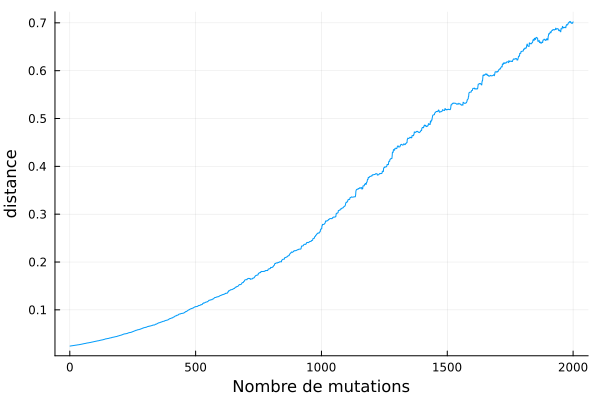

In [21]:
function distance3(sol1,sol2, n, k)
    """
    Distance entropique
    """
    X=zeros(Int, n, k)
    Y=zeros(Int, n, k)
    for i in 1:n
        X[i, sol1[i]]=1
        Y[i, sol2[i]]=1
    end
    M=transpose(X)*Y
    M2=transpose(M)*M
    T= [sum([M2[c1, c2] for c2 in 1:k]) for c1 in 1:k]
    res=0
    for c1 in 1:k
        for c2 in 1:k
            if M2[c1, c2]!=0
                m1=M2[c1, c2]/T[c1]
                res+=M2[c1, c2]^2
            end
        end
    end
    return 6*k^2/res
end

sol_tabou
sol_taboubis=zeros(Int,n)
for i in 1:n
    sol_taboubis[i]=k+1-sol_tabou[i]
end

plot([distance3(sol_tabou,mutation(sol_taboubis,1, n, k), n, k) for i in 1:2*n], label="",xlabel="Nombre de mutations", ylabel="distance", legend=false)